In [1]:
import os
import sys
import random
import json
import collections
import itertools

import pandas as pd
import numpy as np
import scipy
import statsmodels


from tqdm import trange, tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


pd.options.display.max_columns = 999

sns.set()
plt.rcParams["figure.figsize"] = (10,7)

In [23]:
from sklearn.preprocessing import normalize

In [2]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
labelled_dataset_path = '../data/processed/labelled_features.csv'

In [5]:
df = pd.read_csv(labelled_dataset_path)

In [6]:
df.head()

,left_spec_id,right_spec_id,label,left_page_title__00,left_page_title__01,left_page_title__013803105384,left_page_title__013803117493,left_page_title__013803129052,left_page_title__013803136340,left_page_title__018208254682,left_page_title__018208254781,left_page_title__018208254804,left_page_title__0mp,left_page_title__10,left_page_title__100,left_page_title__105,left_page_title__105mm,left_page_title__1080,left_page_title__1080p,left_page_title__10mp,left_page_title__10x,left_page_title__110,left_page_title__1100d,left_page_title__12,left_page_title__1280,left_page_title__12mm,left_page_title__12mp,left_page_title__12x,left_page_title__135,left_page_title__135mm,left_page_title__14,left_page_title__14mp,left_page_title__15,left_page_title__150,left_page_title__16,left_page_title__16gb,left_page_title__16mp,left_page_title__16x,left_page_title__17,left_page_title__18,left_page_title__18mp,left_page_title__1920,left_page_title__1d,left_page_title__1mp,left_page_title__20,left_page_title__200,left_page_title__200mm,left_page_title__2013,left_page_title__2014,left_page_title__20x,left_page_title__21,left_page_title__21x,left_page_title__22,left_page_title__24,left_page_title__24gb,left_page_title__250mm,left_page_title__264,left_page_title__28,left_page_title__2cd2012,left_page_title__2cd2032,left_page_title__2cd2112,left_page_title__2cd2132,left_page_title__2cd2212,left_page_title__2cd2232,left_page_title__2cd2332,left_page_title__2cd2532f,left_page_title__2cd2612f,left_page_title__2cd2632f,left_page_title__2cd2712f,left_page_title__2cd3332,left_page_title__2de7174,left_page_title__2mp,left_page_title__30,left_page_title__300,left_page_title__300mm,left_page_title__30m,left_page_title__30mm,left_page_title__30x,left_page_title__32,left_page_title__32gb,left_page_title__35,left_page_title__35mm,left_page_title__36,left_page_title__360,left_page_title__3d,left_page_title__3g,left_page_title__3megapixel,left_page_title__3mp,left_page_title__3x,left_page_title__40,left_page_title__40d,left_page_title__42,left_page_title__42mm,left_page_title__4608,left_page_title__49,left_page_title__4gb,left_page_title__4mp,left_page_title__4x,left_page_title__50,left_page_title__500,left_page_title__500d,left_page_title__50d,left_page_title__50mm,left_page_title__55,left_page_title__550d,left_page_title__55mm,left_page_title__5d,left_page_title__5mp,left_page_title__5x,left_page_title__60,left_page_title__600d,left_page_title__60d,left_page_title__6d,left_page_title__6g,left_page_title__6mp,left_page_title__6x,left_page_title__70,left_page_title__700d,left_page_title__700tvl,left_page_title__70d,left_page_title__70mm,left_page_title__720,left_page_title__720p,left_page_title__75,left_page_title__7d,left_page_title__85mm,left_page_title__8gb,left_page_title__8mp,left_page_title__8x,left_page_title__90,left_page_title__95,left_page_title__960p,left_page_title__98,left_page_title__99,left_page_title__a20,left_page_title__accessories,left_page_title__accessory,left_page_title__action,left_page_title__af,left_page_title__ahd,left_page_title__ahmedabad,left_page_title__alarm,left_page_title__alibaba,left_page_title__all,left_page_title__allwinner,left_page_title__alpha,left_page_title__aluminum,left_page_title__analog,left_page_title__and,left_page_title__android,left_page_title__angle,left_page_title__anti,left_page_title__array,left_page_title__as,left_page_title__at,left_page_title__audio,left_page_title__australia,left_page_title__auto,left_page_title__backpack,left_page_title__bag,left_page_title__bags,left_page_title__bangalore,left_page_title__batteries,left_page_title__battery,left_page_title__best,left_page_title__big,left_page_title__black,left_page_title__blue,left_page_title__body,left_page_title__box,left_page_title__boxed,left_page_title__brand,left_page_title__brown,left_page_title__built,left_page_title__bullet,left_page_title__bundle,left_page_title__buy,left_page_title__buzzillions,left_page_title__by,left_page_title__cable,left_page_

# Obtain classes from labels

Each class - camera model. All specs that are duplicates of eachother consitute the same class. In a graph one class = one connected component.

In [7]:
dup_df = df[df.label==1][['left_spec_id', 'right_spec_id', 'label']].sort_values(by=['left_spec_id', 'right_spec_id'])

In [8]:
dup_df.shape

(3582, 3)

In [9]:
dup_df.head()

,left_spec_id,right_spec_id,label
27484,buy.net//5641,www.ebay.com//58588,1
24490,buy.net//5641,www.gosale.com//849,1
12459,buy.net//5641,www.price-hunt.com//9794,1
5120,buy.net//5698,cammarkt.com//501,1
31627,buy.net//5698,www.ebay.com//41940,1


In [10]:
len(set(dup_df.left_spec_id).intersection(dup_df.right_spec_id))

252

In [11]:
class_mapping = {
    
}

def replace_class_mapping(prev_class, new_class):
    for k in class_mapping:
        if k == prev_class:
            class_mapping[k] = new_class

cur_class = 0
for row in dup_df.itertuples():
    if row.left_spec_id in class_mapping or row.right_spec_id in class_mapping:
        if row.left_spec_id in class_mapping and row.right_spec_id in class_mapping and class_mapping[row.left_spec_id] != class_mapping[row.right_spec_id]:
            raise Exception('wtf')
        
        existing_class = class_mapping.get(row.left_spec_id, class_mapping.get(row.right_spec_id))
        class_mapping[row.left_spec_id] = existing_class
        class_mapping[row.right_spec_id] = existing_class
    else:
        class_mapping[row.left_spec_id] = cur_class
        class_mapping[row.right_spec_id] = cur_class
        cur_class += 1


In [12]:
classes_df = pd.DataFrame({'spec_id': list(class_mapping.keys()), 'class_': list(class_mapping.values())})
classes_df.shape

(306, 2)

In [13]:
classes_df.head()

,spec_id,class_
0,buy.net//5641,0
1,www.ebay.com//58588,0
2,www.gosale.com//849,0
3,www.price-hunt.com//9794,0
4,buy.net//5698,1


# Get specs features

In [14]:
specs_df = pd.read_csv('../data/processed/specs_features.csv')
# specs_df.drop(['site', 'page_title', 'page_title_stem'], axis=1, inplace=True)
specs_df.shape

(29787, 1304)

In [15]:
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site,page_title__00,page_title__01,page_title__013803105384,page_title__013803117493,page_title__013803129052,page_title__013803136340,page_title__018208254682,page_title__018208254781,page_title__018208254804,page_title__0mp,page_title__10,page_title__100,page_title__105,page_title__105mm,page_title__1080,page_title__1080p,page_title__10mp,page_title__10x,page_title__110,page_title__1100d,page_title__12,page_title__1280,page_title__12mm,page_title__12mp,page_title__12x,page_title__135,page_title__135mm,page_title__14,page_title__14mp,page_title__15,page_title__150,page_title__16,page_title__16gb,page_title__16mp,page_title__16x,page_title__17,page_title__18,page_title__18mp,page_title__1920,page_title__1d,page_title__1mp,page_title__20,page_title__200,page_title__200mm,page_title__2013,page_title__2014,page_title__20x,page_title__21,page_title__21x,page_title__22,page_title__24,page_title__24gb,page_title__250mm,page_title__264,page_title__28,page_title__2cd2012,page_title__2cd2032,page_title__2cd2112,page_title__2cd2132,page_title__2cd2212,page_title__2cd2232,page_title__2cd2332,page_title__2cd2532f,page_title__2cd2612f,page_title__2cd2632f,page_title__2cd2712f,page_title__2cd3332,page_title__2de7174,page_title__2mp,page_title__30,page_title__300,page_title__300mm,page_title__30m,page_title__30mm,page_title__30x,page_title__32,page_title__32gb,page_title__35,page_title__35mm,page_title__36,page_title__360,page_title__3d,page_title__3g,page_title__3megapixel,page_title__3mp,page_title__3x,page_title__40,page_title__40d,page_title__42,page_title__42mm,page_title__4608,page_title__49,page_title__4gb,page_title__4mp,page_title__4x,page_title__50,page_title__500,page_title__500d,page_title__50d,page_title__50mm,page_title__55,page_title__550d,page_title__55mm,page_title__5d,page_title__5mp,page_title__5x,page_title__60,page_title__600d,page_title__60d,page_title__6d,page_title__6g,page_title__6mp,page_title__6x,page_title__70,page_title__700d,page_title__700tvl,page_title__70d,page_title__70mm,page_title__720,page_title__720p,page_title__75,page_title__7d,page_title__85mm,page_title__8gb,page_title__8mp,page_title__8x,page_title__90,page_title__95,page_title__960p,page_title__98,page_title__99,page_title__a20,page_title__accessories,page_title__accessory,page_title__action,page_title__af,page_title__ahd,page_title__ahmedabad,page_title__alarm,page_title__alibaba,page_title__all,page_title__allwinner,page_title__alpha,page_title__aluminum,page_title__analog,page_title__and,page_title__android,page_title__angle,page_title__anti,page_title__array,page_title__as,page_title__at,page_title__audio,page_title__australia,page_title__auto,page_title__backpack,page_title__bag,page_title__bags,page_title__bangalore,page_title__batteries,page_title__battery,page_title__best,page_title__big,page_title__black,page_title__blue,page_title__body,page_title__box,page_title__boxed,page_title__brand,page_title__brown,page_title__built,page_title__bullet,page_title__bundle,page_title__buy,page_title__buzzillions,page_title__by,page_title__cable,page_title__cam,page_title__cambuy,page_title__camcorder,page_title__camedia,page_title__camera,page_title__camerafarm,page_title__cameras,page_title__cammarkt,page_title__canon,page_title__canvas,page_title__car,page_title__card,page_title__carry,page_title__carrying,page_title__case,page_title__cases,page_title__casio,page_title__ccd,page_title__cctv,page_title__charger,page_title__cheap,page_title__chennai,page_title__china,page_title__cmos,page_title__color,page_title__colorful,page_title__com,page_title__compact,page_title__comparison,page_title__complete,page_title__condition,page_title__connection,page_title__coolpix,page_title__core,page_title__cost,page_title__count,page_title__cover,page_title__cube,page_title__custom,page_title__cut,page_title__cute,page_title__cyber,page_title__cybershot,page_title__d200,page_title__d300,page_title__d3000,page_title__d3100,p

In [16]:
specs_df = specs_df.merge(classes_df, on='spec_id', how='left')

In [17]:
specs_df.shape

(29787, 1305)

In [18]:
specs_df[~specs_df.class_.isnull()][['spec_id', 'page_title', 'class_', 'brand']].sort_values(by='class_').head()

,spec_id,page_title,class_,brand
12755,www.ebay.com//54217,Near Mint Nikon Camera D4 Body 16 2 MP FX Free...,0.0,nikon
14521,www.price-hunt.com//9794,"Nikon D4 DSLR Camera best price in India 2014,...",0.0,nikon
18868,buy.net//5641,Nikon D4 Black SLR Digital Camera - Body Only ...,0.0,nikon
1479,www.ebay.com//59612,Excellent Nikon Camera D4 Body 16 2 MP FX Free...,0.0,nikon
28537,www.gosale.com//849,Nikon D4 16.2MP CMOS FX Digital SLR on sale fo...,0.0,nikon


In [19]:
specs_classes = specs_df.class_

In [20]:
spec_features = specs_df.drop(['spec_id', 'site', 'brand', 'page_title', 'page_title_stem', 'class_'], axis=1)
spec_features.shape

(29787, 1299)

In [21]:
spec_features.head()

,page_title__00,page_title__01,page_title__013803105384,page_title__013803117493,page_title__013803129052,page_title__013803136340,page_title__018208254682,page_title__018208254781,page_title__018208254804,page_title__0mp,page_title__10,page_title__100,page_title__105,page_title__105mm,page_title__1080,page_title__1080p,page_title__10mp,page_title__10x,page_title__110,page_title__1100d,page_title__12,page_title__1280,page_title__12mm,page_title__12mp,page_title__12x,page_title__135,page_title__135mm,page_title__14,page_title__14mp,page_title__15,page_title__150,page_title__16,page_title__16gb,page_title__16mp,page_title__16x,page_title__17,page_title__18,page_title__18mp,page_title__1920,page_title__1d,page_title__1mp,page_title__20,page_title__200,page_title__200mm,page_title__2013,page_title__2014,page_title__20x,page_title__21,page_title__21x,page_title__22,page_title__24,page_title__24gb,page_title__250mm,page_title__264,page_title__28,page_title__2cd2012,page_title__2cd2032,page_title__2cd2112,page_title__2cd2132,page_title__2cd2212,page_title__2cd2232,page_title__2cd2332,page_title__2cd2532f,page_title__2cd2612f,page_title__2cd2632f,page_title__2cd2712f,page_title__2cd3332,page_title__2de7174,page_title__2mp,page_title__30,page_title__300,page_title__300mm,page_title__30m,page_title__30mm,page_title__30x,page_title__32,page_title__32gb,page_title__35,page_title__35mm,page_title__36,page_title__360,page_title__3d,page_title__3g,page_title__3megapixel,page_title__3mp,page_title__3x,page_title__40,page_title__40d,page_title__42,page_title__42mm,page_title__4608,page_title__49,page_title__4gb,page_title__4mp,page_title__4x,page_title__50,page_title__500,page_title__500d,page_title__50d,page_title__50mm,page_title__55,page_title__550d,page_title__55mm,page_title__5d,page_title__5mp,page_title__5x,page_title__60,page_title__600d,page_title__60d,page_title__6d,page_title__6g,page_title__6mp,page_title__6x,page_title__70,page_title__700d,page_title__700tvl,page_title__70d,page_title__70mm,page_title__720,page_title__720p,page_title__75,page_title__7d,page_title__85mm,page_title__8gb,page_title__8mp,page_title__8x,page_title__90,page_title__95,page_title__960p,page_title__98,page_title__99,page_title__a20,page_title__accessories,page_title__accessory,page_title__action,page_title__af,page_title__ahd,page_title__ahmedabad,page_title__alarm,page_title__alibaba,page_title__all,page_title__allwinner,page_title__alpha,page_title__aluminum,page_title__analog,page_title__and,page_title__android,page_title__angle,page_title__anti,page_title__array,page_title__as,page_title__at,page_title__audio,page_title__australia,page_title__auto,page_title__backpack,page_title__bag,page_title__bags,page_title__bangalore,page_title__batteries,page_title__battery,page_title__best,page_title__big,page_title__black,page_title__blue,page_title__body,page_title__box,page_title__boxed,page_title__brand,page_title__brown,page_title__built,page_title__bullet,page_title__bundle,page_title__buy,page_title__buzzillions,page_title__by,page_title__cable,page_title__cam,page_title__cambuy,page_title__camcorder,page_title__camedia,page_title__camera,page_title__camerafarm,page_title__cameras,page_title__cammarkt,page_title__canon,page_title__canvas,page_title__car,page_title__card,page_title__carry,page_title__carrying,page_title__case,page_title__cases,page_title__casio,page_title__ccd,page_title__cctv,page_title__charger,page_title__cheap,page_title__chennai,page_title__china,page_title__cmos,page_title__color,page_title__colorful,page_title__com,page_title__compact,page_title__comparison,page_title__complete,page_title__condition,page_title__connection,page_title__coolpix,page_title__core,page_title__cost,page_title__count,page_title__cover,page_title__cube,page_title__custom,page_title__cut,page_title__cute,page_title__cyber,page_title__cybershot,page_title__d200,page_title__d300,page_title__d3000,page_title__d3100,page_title__d3200,page_title__d3300,page_title_

# Pairwise distances distirubtion

In [103]:
from scipy.spatial.distance import pdist, cdist

In [104]:
sample_features = normalize(spec_features.sample(5000))

In [108]:
pairwise_distances = pdist(sample_features)

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


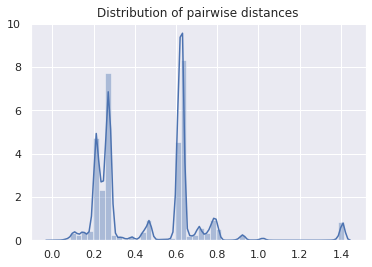

In [109]:
plt.figure()
plt.title('Distribution of pairwise distances')
sns.distplot(pairwise_distances)
plt.show()

In [110]:
def get_features_for_spec_id(spec_id):
    return spec_features.iloc[specs_df[specs_df.spec_id==spec_id].index[0]].values
get_features_for_spec_id('www.ebay.com//42835')

array([0., 0., 0., ..., 0., 0., 7.])

In [111]:
duplicate_pairs = dup_df.sample(1000)[['left_spec_id', 'right_spec_id']].values

duplicate_vector_pairs = []
for s1, s2 in duplicate_pairs:
    duplicate_vector_pairs.append([
        get_features_for_spec_id(s1),
        get_features_for_spec_id(s2)
    ])
    
duplicate_vector_pairs = np.array(duplicate_vector_pairs)

duplicate_vector_pairs[:3]

array([[[ 0.,  0.,  0., ...,  0.,  0.,  7.],
        [ 0.,  0.,  0., ...,  0.,  0.,  7.]],

       [[ 0.,  0.,  0., ...,  0.,  0., 10.],
        [ 0.,  0.,  0., ...,  0.,  0.,  7.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  7.],
        [ 0.,  0.,  0., ...,  0.,  0., 11.]]])

In [112]:
non_duplicate_pairs = df[df.label==0].sample(1000)[['left_spec_id', 'right_spec_id']].values

non_duplicate_vector_pairs = []
for s1, s2 in non_duplicate_pairs:
    non_duplicate_vector_pairs.append([
        get_features_for_spec_id(s1),
        get_features_for_spec_id(s2)
    ])

        
non_duplicate_vector_pairs = np.array(non_duplicate_vector_pairs)
non_duplicate_vector_pairs[:3]

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  7.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  7.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , 23.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.2218487 ,
          0.        , 18.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  7.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.22322817,  7.        ]]])

In [113]:
duplicate_vector_pairs.shape

(1000, 2, 1299)

In [114]:
def compute_pairwise_distances(pairs_arr):
    dists = []
    for i in range(len(pairs_arr)):
        dists.append(pdist(pairs_arr[i])[0])
    return dists

In [115]:
duplicate_vector_pairs.shape

(1000, 2, 1299)

In [116]:
duplicate_distances = compute_pairwise_distances(duplicate_vector_pairs)
non_duplicate_distances = compute_pairwise_distances(non_duplicate_vector_pairs)

In [117]:
len(duplicate_distances), len(non_duplicate_distances)

(1000, 1000)

/home/boris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


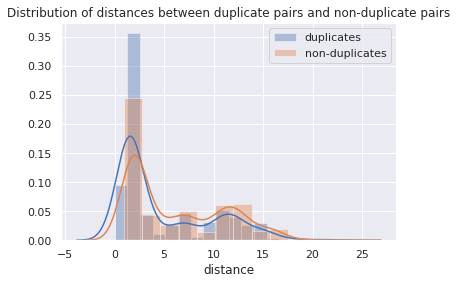

In [119]:
plt.figure()
plt.title('Distribution of distances between duplicate pairs and non-duplicate pairs')
sns.distplot(duplicate_distances, label='duplicates')
sns.distplot(non_duplicate_distances, label='non-duplicates')
plt.legend()
plt.xlabel('distance')
plt.show()

### Duplicates are more likely to have a small distance, but currenlty the embedding is crap

# TSNE visualization

In [120]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [121]:
tsne = TSNE(
    n_components=2,
    metric='cosine',
    n_jobs=3,
    verbose=True,
)

In [122]:
spec_features_ld = tsne.fit_transform(spec_features)

In [123]:
spec_features_ld.shape

(29787, 2)

In [124]:
spec_features_ld = pd.DataFrame(spec_features_ld)
spec_features_ld['class_'] = specs_classes
spec_features_ld.shape

(29787, 3)

In [125]:
specs_df['class_'].iloc[46]

6.0

In [126]:
spec_features_ld.iloc[46]

0         34.026586
1         -0.849935
class_     6.000000
Name: 46, dtype: float64

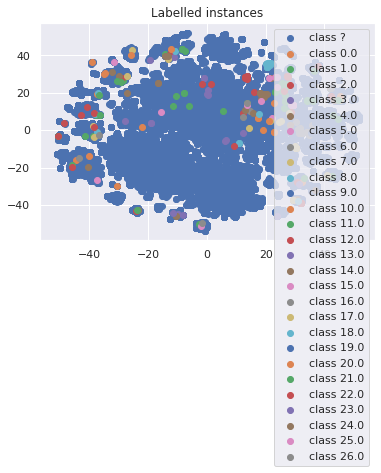

In [127]:
plt.figure()
plt.title('Labelled instances')
class_ld_df = spec_features_ld[pd.isnull(spec_features_ld.class_)]
plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class ?')

for class_ in spec_features_ld['class_'].sort_values().unique():
    if pd.isnull(class_):
        continue
    class_ld_df = spec_features_ld[spec_features_ld.class_==class_]
    plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class {class_}')

plt.legend()
plt.show()

## Either the embedding vectors are shit, or the visualization is shit